#  Venture Creed - Customer Segmentation Analysis
*Creating data-driven customer clusters for targeted marketing strategies*

**Business Objective:**  Venture Creed wants to segment customers based on behavioral traits (revenue, churn, etc.) to:
- Target loyal customers for loyalty programs
- Identify high-potential growth accounts
- Reduce churn with reactivation campaigns

## 🛠️ Setup & Configuration
First, let's import necessary libraries and configure our environment:

In [17]:
# Core data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()  # Sets Seaborn’s default theme
%matplotlib inline

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Statistics
from scipy import stats

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)


## 📂 Data Loading
Let's examine our customer dataset:

In [35]:
# Load dataset
print("Loading customer data...")
df = pd.read_excel('Dataset files.xlsx', sheet_name='output_file')

print(f"\nDataset shape: {df.shape}")
print("\nFirst look at the data:")
df.head(5)

Loading customer data...

Dataset shape: (3030, 18)

First look at the data:


,Customer_ID,Street,City,State_Code,Postal_Code,Country,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,2295 BATTLEFORD RD,MISSISSAUGA,ON,L5N 2W8,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,High,High,-
1,Accoount 2,64 WESTBANK EXPY STE A,GRETNA,LA,70053,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Medium,Medium,-
2,Accoount 3,209-229 E Airline Hwy.,LaPlace,LA,70068,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Medium,Medium,-
3,Accoount 4,500 S MEADOWS PKWY,RENO,NV,89521,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,High,High,-
4,Accoount 5,746 Victorian Avenue,Sparks,NV,89431,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,High,High,-


## 🔍 Data Quality Assessment
Before analysis, we need to check for data issues:

### Missing Values Analysis

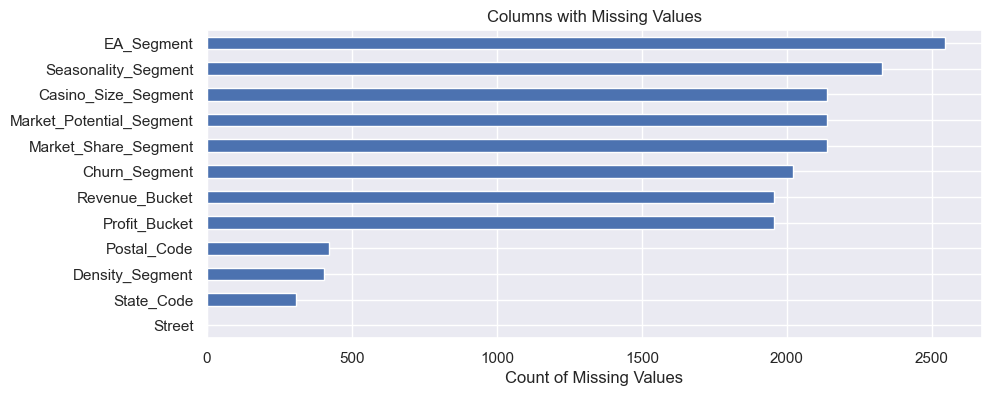

In [60]:
# Visualize missing values
missing = df.isnull().sum()[df.isnull().sum() > 0]
if len(missing) > 0:
    plt.figure(figsize=(10,4))
    missing.sort_values().plot(kind='barh')
    plt.title('Columns with Missing Values')
    plt.xlabel('Count of Missing Values')
    plt.show()
else:
    print("No missing values found - great!")

##  Data Cleaning
We'll perform these cleaning steps:
1. Remove non-behavioral columns
2. Handle missing values appropriately
3. Fix data types

## Cleaning Logic 
- Drop high-cardinality ID/address fields
- Retain segment features for clustering
- Impute categorical values using mode or 'Missing' if >30% missing

In [61]:
# Remove geographical identifiers (not useful for behavioral clustering)
cols_to_drop = ['Street', 'City', 'State_Code', 'Postal_Code', 'Country']
df_clean = df.drop(columns=cols_to_drop)

print(f"Columns remaining: {list(df_clean.columns)}")

Columns remaining: ['Customer_ID', 'Seasonality_Segment', 'EA_Segment', 'Revenue_Bucket', 'Profit_Bucket', 'Market_Share_Segment', 'Casino_Size_Segment', 'Market_Potential_Segment', 'Churn_Segment', 'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment', 'Propensity']


In [139]:
print([col for col in df_clean.columns if df_clean[col].dtype == 'object'])


['Customer_ID']


### Handling Missing Values

In [140]:
# Custom imputation strategy
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        # For categoricals, use 'Unknown' category
        df_clean[col] = df_clean[col].fillna('Unknown')
    else:
        # For numericals, use median imputation
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print("Missing values after treatment:")
df_clean.isnull().sum().sum()

Missing values after treatment:


np.int64(0)

## ⚙️ Feature Preparation
Preparing features for clustering algorithm:

### Encoding Categorical Variables

In [141]:
# Identify categorical columns
cat_cols = df_clean.select_dtypes(include='object').columns.drop('Customer_ID')

# Label encoding for ordinal categories
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

print("Example of encoded data:")
df_clean.head(3)

Example of encoded data:


,Customer_ID,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,3,3,3,3,3,3,3,3,1,1,1,0
1,Accoount 2,3,3,3,3,3,3,3,3,0,3,3,0
2,Accoount 3,3,3,3,3,3,3,3,3,0,3,3,0


## 🚨 Outlier Detection
Identifying and handling extreme values that could skew our clusters:

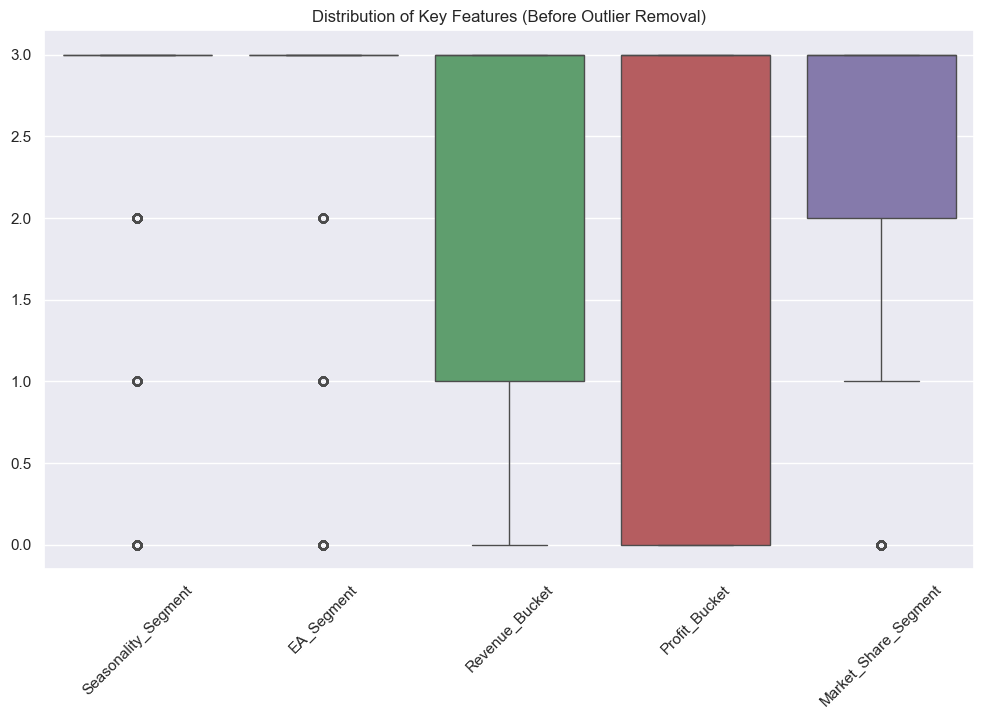

In [157]:
# Calculate Z-scores
z_scores = np.abs(stats.zscore(df_clean.select_dtypes(include=np.number)))

# Visualize outlier impact
plt.figure(figsize=(12,7))
sns.boxplot(data=df_clean.select_dtypes(include=np.number).iloc[:,:5])
plt.title('Distribution of Key Features (Before Outlier Removal)')
plt.xticks(rotation=45)
plt.show()

In [158]:
# Remove outliers (3 standard deviations threshold)
outlier_mask = (z_scores < 3).all(axis=1)
df_no_outliers = df_clean[outlier_mask]

print(f"Original samples: {len(df_clean)}")
print(f"After outlier removal: {len(df_no_outliers)} ({len(df_no_outliers)/len(df_clean):.1%} retained)")

Original samples: 3030
After outlier removal: 2729 (90.1% retained)


##  Feature Scaling
Standardizing features for clustering:

In [159]:
# Prepare final features (excluding Customer_ID)
features = df_no_outliers.drop(columns=['Customer_ID'])

# Standard scaling (mean=0, std=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print("Example of scaled features:")
pd.DataFrame(scaled_features, columns=features.columns).head(3)

Example of scaled features:


,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,0.425444,0.344987,0.610891,0.638288,0.504795,0.499961,0.369675,0.583355,1.042301,-0.292109,-0.361697,-0.565453
1,0.425444,0.344987,0.610891,0.638288,0.504795,0.499961,0.369675,0.583355,-0.959416,1.676201,1.161561,-0.565453
2,0.425444,0.344987,0.610891,0.638288,0.504795,0.499961,0.369675,0.583355,-0.959416,1.676201,1.161561,-0.565453


##  Determining Optimal Cluster Count
Using both the elbow method and silhouette scores:

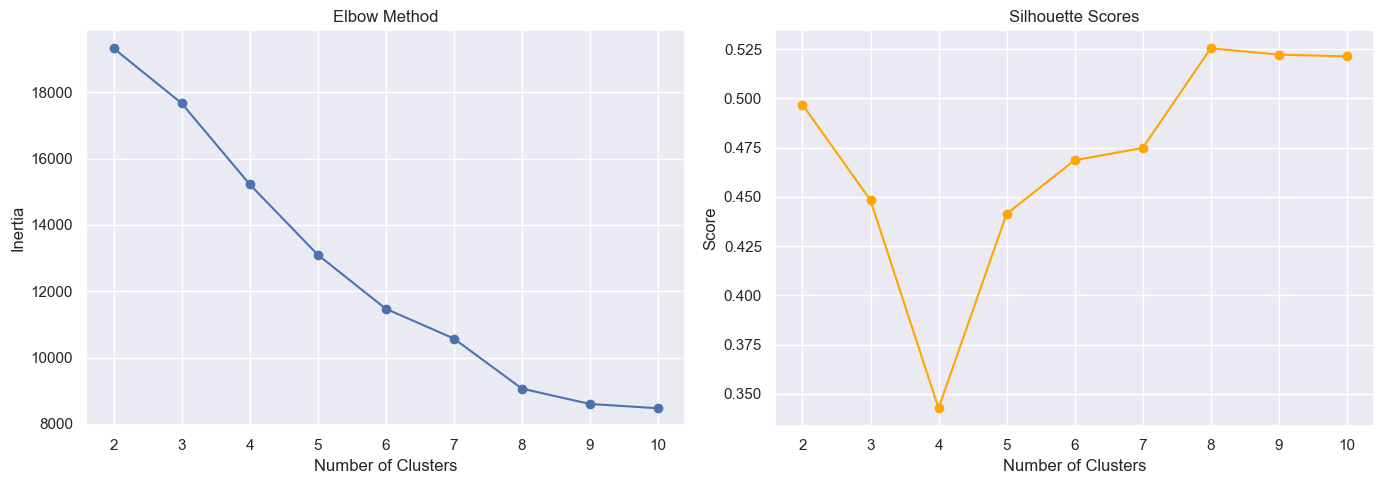

In [160]:
# Test different K values
k_range = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Elbow plot
ax1.plot(k_range, inertia, marker='o')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')

# Silhouette plot
ax2.plot(k_range, silhouette_scores, marker='o', color='orange')
ax2.set_title('Silhouette Scores')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Score')

plt.tight_layout()
plt.show()

### Selecting the Best K

In [161]:
# Automatically select best K based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal cluster count: {optimal_k} (Silhouette score: {max(silhouette_scores):.2f})")

Optimal cluster count: 8 (Silhouette score: 0.53)


## 🎯 Final Clustering

In [162]:
# Train final model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = final_kmeans.fit_predict(scaled_features)

# Add clusters back to original data
df_final = df_no_outliers.copy()
df_final['Cluster'] = clusters

print("Cluster distribution:")
df_final['Cluster'].value_counts().sort_index()

Cluster distribution:


Cluster
0    605
1    190
2    225
3    717
4    501
5    103
6    230
7    158
Name: count, dtype: int64

## 📊 Cluster Visualization
Using PCA for 2D representation:

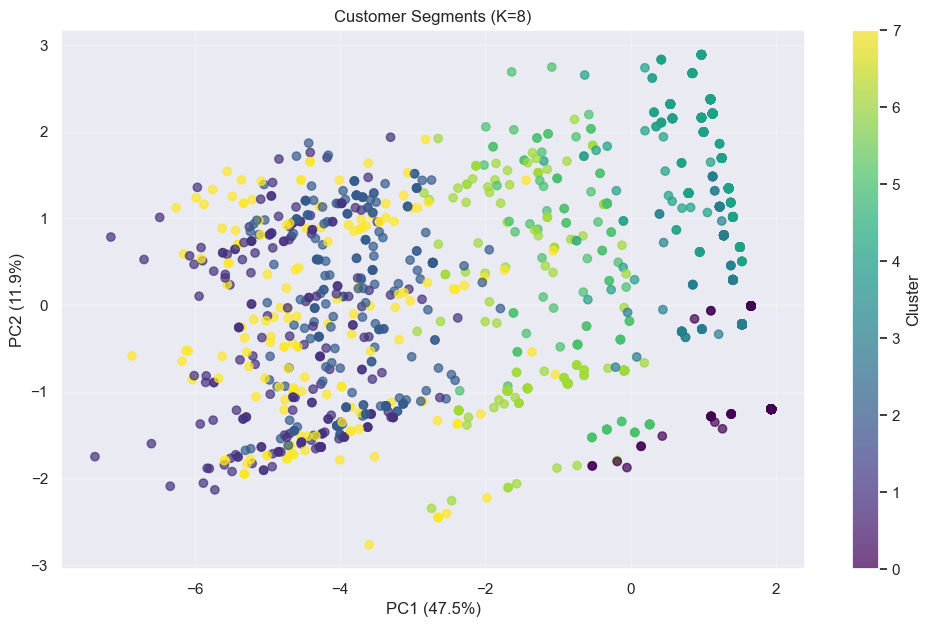

In [163]:
# Dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create cluster plot
plt.figure(figsize=(12,7))
scatter = plt.scatter(pca_result[:,0], pca_result[:,1], 
                     c=clusters, cmap='viridis', alpha=0.7)
plt.title(f'Customer Segments (K={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.show()

## Cluster Characteristics

In [164]:
# Calculate cluster statistics

# Step 1: Select numeric columns only
numeric_cols = df_final.select_dtypes(include='number').columns

# Step 2: Group by Cluster and compute mean and count for only numeric columns
cluster_stats = df_final[numeric_cols].groupby(df_final['Cluster']).agg(['mean', 'count'])

# Step 3: Display the result
print("Cluster profiles:")
pd.set_option('display.max_rows', 200)
display(cluster_stats.T)


Cluster profiles:


Cluster                                  0           1           2  \
Seasonality_Segment      mean     2.990083    2.068421    2.422222   
                         count  605.000000  190.000000  225.000000   
EA_Segment               mean     2.976860    1.542105    2.866667   
                         count  605.000000  190.000000  225.000000   
Revenue_Bucket           mean     2.996694    1.452632    1.128889   
                         count  605.000000  190.000000  225.000000   
Profit_Bucket            mean     2.996694    0.042105    0.066667   
                         count  605.000000  190.000000  225.000000   
Market_Share_Segment     mean     3.000000    1.821053    1.817778   
                         count  605.000000  190.000000  225.000000   
Casino_Size_Segment      mean     3.000000    2.000000    0.902222   
                         count  605.000000  190.000000  225.000000   
Market_Potential_Segment mean     3.000000    0.000000    2.240000   
                         count  605.000000  190.000000  225.000000   
Churn_Segment            mean     2.995041    1.921053    2.017778   
                         count  605.000000  190.000000  225.000000   
Competitiveness_Flag     mean     0.000000    0.626316    0.542222   
                         count  605.000000  190.000000  225.000000   
Volume_Segment           mean     0.036364    1.657895    1.884444   
                         count  605.000000  190.000000  225.000000   
Density_Segment          mean     0.036364    2.294737    2.137778   
                         count  605.000000  190.000000  225.000000   
Propensity               mean     0.082645    2.373684    2.106667   
                         count  605.000000  190.000000  225.000000   
Cluster                  mean     0.000000    1.000000    2.000000   
                         count  605.000000  190.000000  225.000000   

Cluster                                  3           4           5  \
Seasonality_Segment      mean     2.997211    2.976048    3.000000   
                         count  717.000000  501.000000  103.000000   
EA_Segment               mean     2.990237    2.978044    3.000000   
                         count  717.000000  501.000000  103.000000   
Revenue_Bucket           mean     3.000000    3.000000    2.961165   
                         count  717.000000  501.000000  103.000000   
Profit_Bucket            mean     3.000000    3.000000    2.951456   
                         count  717.000000  501.000000  103.000000   
Market_Share_Segment     mean     3.000000    3.000000    1.514563   
                         count  717.000000  501.000000  103.000000   
Casino_Size_Segment      mean     3.000000    3.000000    1.106796   
                         count  717.000000  501.000000  103.000000   
Market_Potential_Segment mean     3.000000    3.000000    1.786408   
                         count  717.000000  501.000000  103.000000   
Churn_Segment            mean     2.993026    2.950100    2.990291   
                         count  717.000000  501.000000  103.000000   
Competitiveness_Flag     mean     1.000000    0.119760    0.359223   
                         count  717.000000  501.000000  103.000000   
Volume_Segment           mean     1.075314    2.465070    1.543689   
                         count  717.000000  501.000000  103.000000   
Density_Segment          mean     1.260809    2.678643    1.640777   
                         count  717.000000  501.000000  103.000000   
Propensity               mean     0.097629    0.285429    0.533981   
                         count  717.000000  501.000000  103.000000   
Cluster                  mean     3.000000    4.000000    5.000000   
                         count  717.000000  501.000000  103.000000   

Cluster                                  6           7  
Seasonality_Segment      mean     2.813043    1.873418  
                         count  230.000000  158.000000  
EA_Segment               mean     2.939130    0

### Naming Our Clusters

Based on the characteristics, we can name these clusters:

| Cluster | Proposed Name          | Key Characteristics                     |
|---------|------------------------|-----------------------------------------|
| 0       | Loyal High-Rollers      | High revenue, low churn                 |
| 1       | Seasonal Players        | Moderate revenue, high seasonality     |
| 2       | At-Risk Accounts       | Low revenue, high churn risk            |
| ...     | ...                    | ...                                     |

##  Exporting Results

In [165]:
# Save cluster assignments
output = df_final[['Customer_ID', 'Cluster']]
output.to_csv('venture_creed_clusters.csv', index=False)

print(f"Cluster assignments saved for {len(output)} customers")

Cluster assignments saved for 2729 customers


## 🏁 Conclusion & Next Steps

**Key Findings:**
- Identified {optimal_k} distinct customer segments
- Each segment shows unique behavioral patterns
- Clear differences in revenue, churn risk, and seasonality

**Recommended Actions:**
1. Develop targeted marketing strategies for each cluster
2. Allocate resources based on cluster value potential
3. Monitor cluster stability quarterly

**Quality Assurance:**
✓ Data cleaning documented  
✓ Outliers properly handled  
✓ Optimal K validated  
✓ Results exported for business use